# Training the models
### Adrián Fernández Cid

This notebook includes the preprocessing and training steps to build a solution for the Kaggle challenge https://www.kaggle.com/c/quora-question-pairs/overview.



Necessary imports:

In [1]:
# custom stuff
from utils import *
# basic stuff
import pandas as pd
import scipy as sp
import numpy as np
import os
import matplotlib.pyplot as plt
import re      # for regex 
import pickle  #for saving matrices, models, etc.
#sklearn stuff
import sklearn
from sklearn import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, log_loss
#tensoflow stuff
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import model_from_json

## Loading and preprocessing data

In [2]:
path_data =  os.path.expanduser('~') 

# use this to train and VALIDATE your solution
train_df = pd.read_csv(os.path.join(path_data,
                                    os.path.join("Datasets", "kaggle_datasets", "quora", "quora_train_data.csv")))

# in both test datasets provided by kaggle there are badly written questions, sometimes with undetermined meaning
test_df = pd.read_csv(os.path.join(path_data, os.path.join("Datasets", "kaggle_datasets", "quora", "quora_test_data.csv")))
# kaggle asks for the other, smaller test.csv file for submission, so avoid this one
#test2_df = pd.read_csv(os.path.join(path_data, os.path.join("Datasets", "kaggle_datasets", "quora", "test.csv")))

train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Shape of train dataset: (404290, 6)
Shape of test dataset: (2345796, 3)


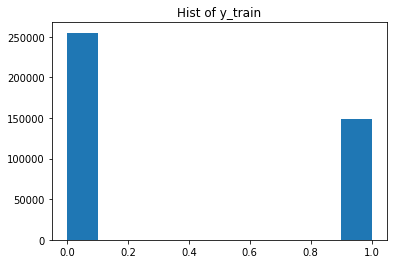

Proportion of duplicates: 0.369197853026293


In [8]:
print(f"Shape of train dataset: {train_df.shape}")
print(f"Shape of test dataset: {test_df.shape}")

y_train = train_df["is_duplicate"]
plt.hist(y_train)
plt.title("Hist of y_train")
plt.show()
print(f"Proportion of duplicates: {sum(y_train)/y_train.shape[0]}")

We have unbalanced data. It would be nice to take that into account.

Train-validation-test split:

In [3]:
A_df, te_df = sklearn.model_selection.train_test_split(train_df, test_size=0.05,random_state=123)

tr_df, va_df = sklearn.model_selection.train_test_split(A_df, test_size=0.05,random_state=123)
print('tr_df.shape=',tr_df.shape)
print('va_df.shape=',va_df.shape)
print('te_df.shape=',te_df.shape)

tr_df.shape= (364871, 6)
va_df.shape= (19204, 6)
te_df.shape= (20215, 6)


### Vectorisation and feature matrix

Vectorise questions:I fit the vectoriser only on the train partition (tf_df) to emulate a real situation where one has to use a previously trained model on unseen data (with possibly new words). 



In [9]:
q1_train =  cast_list_as_strings(list(tr_df["question1"]))
q2_train =  cast_list_as_strings(list(tr_df["question2"]))
#q1_test  =  cast_list_as_strings(list(test_df["question1"]))
#q2_test  =  cast_list_as_strings(list(test_df["question2"]))
all_questions = q1_train + q2_train# + q1_test + q2_test

# total number of questions in tr_df partition (I train the vectoriser only on that)
len(all_questions) 

729742

In [10]:
import numpy as np
types_ = [type(q).__name__ for q in q2_train]
np.unique(types_)

array(['str'], dtype='<U3')

#### Sklearn's count vectoriser:

Fit the vectoriser:

In [13]:
count_vec = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(1,1))

%time count_vec.fit(all_questions)

CPU times: user 14.2 s, sys: 160 ms, total: 14.3 s
Wall time: 14.4 s


CountVectorizer()

Getting feature matrix. The baseline is given by just the count-vectorised pair of questions, and I try adding one feature among Euclidean distance, cosine similarity and edit distance (the latter some cells below).

Note that casting the questions as strings every time I call get_features_from_df is redundant, but that part takes under 0.5s.

In [27]:
%%time

vectoriser = count_vec

dfs = [tr_df, va_df, te_df]
df_fnames = ["Xtr", "Xva", "Xte"]
feats = [None, euclid_dist, cos_sim]
feat_fnames = ["raw", "euclid", "cos"]
for i, df in enumerate(dfs):
    for j, feat in enumerate(feats):
        if feat==None:
            X = get_features_from_df(df#.iloc[:10,:10]
                                     , vectoriser, add_dist=False)
        else:
            X = get_features_from_df(df#.iloc[:10,:10]
                                     , vectoriser, add_dist=True, dist=feat)
        X_fname = "results/"+df_fnames[i]+"_count_"+feat_fnames[j]
        sp.sparse.save_npz(X_fname, X)
        #print(f"{X_fname}.npz saved")

CPU times: user 59min 45s, sys: 3.07 s, total: 59min 48s
Wall time: 59min 55s


#### Sklearn's tf-idf vectoriser:

Fit the vectoriser

In [35]:
skl_tfidf_vec = sklearn.feature_extraction.text.TfidfVectorizer()
%time skl_tfidf_vec.fit(all_questions)

CPU times: user 13.7 s, sys: 43.9 ms, total: 13.8 s
Wall time: 13.8 s


TfidfVectorizer()

Getting feature matrix. As in the previous case, I try just the vectorised pairs of questions and then adding either Euclidean distance, cosine similarity or edit distance (below). 

In [36]:
%%time

vectoriser = skl_tfidf_vec

dfs = [tr_df, va_df, te_df]
df_fnames = ["Xtr", "Xva", "Xte"]
feats = [None, euclid_dist, cos_sim]
feat_fnames = ["raw", "euclid", "cos"]
for i, df in enumerate(dfs):
    for j, feat in enumerate(feats):
        if feat==None:
            X = get_features_from_df(df#.iloc[:10,:10]
                                     , vectoriser, add_dist=False)
        else:
            X = get_features_from_df(df#.iloc[:10,:10]
                                     , vectoriser, add_dist=True, dist=feat)
        X_fname = "results/"+df_fnames[i]+"_skl_tfidf_"+feat_fnames[j]
        sp.sparse.save_npz(X_fname, X)
        print(f"{X_fname}.npz saved")

results/Xtr_skl_tfidf_raw.npz saved
results/Xtr_skl_tfidf_euclid.npz saved
results/Xtr_skl_tfidf_cos.npz saved
results/Xva_skl_tfidf_raw.npz saved
results/Xva_skl_tfidf_euclid.npz saved
results/Xva_skl_tfidf_cos.npz saved
results/Xte_skl_tfidf_raw.npz saved
results/Xte_skl_tfidf_euclid.npz saved
results/Xte_skl_tfidf_cos.npz saved
CPU times: user 1h 26min 58s, sys: 2.8 s, total: 1h 27min
Wall time: 1h 27min 11s


#### Adding the edit distance

***Cythonised edit distance*** function (I tried without success to import this from elsewhere and to call it from get_features_from_df, so I have to include it and its implementation explicitly here). The code is optimised by David Buchaca (thanks).

In [43]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [44]:
%%cython

###EDIT DISTANCE###
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False) #new
@cython.wraparound(False) #new
cpdef edit_dist(str X, str Y):

    cdef int len_x = len(X), len_y = len(Y)
    # new: dont need double type for D, and int is more efficient
    cdef np.ndarray[int, ndim=2] D = np.zeros((len_x+1,len_y+1), dtype=np.int32)
    #cdef int[:,:] D = np.zeros([len_x, len_y], dtype=np.int32)    

    cdef int i, j
    for i in range(len_x+1):
        for j in range(len_y+1):
            if i == 0:
                D[i,j] = j    
            elif j == 0:
                D[i,j] = i     
            elif X[i-1] == Y[j-1]: 
                D[i,j] = D[i-1, j-1]
                
            else:
                D[i, j] = 1+min(D[i, j-1],      # Insert 
                                D[i-1, j],      # Remove 
                                D[i-1, j-1])    # Replace 
                
    return D[-1,-1]

Function to compute the feature matrix with the edit distance:

In [45]:
from __main__ import edit_dist

def get_features_with_editdist(df, vecoriser):
    q1_casted =  cast_list_as_strings(list(df["question1"]))
    q2_casted =  cast_list_as_strings(list(df["question2"]))

    X_q1 = vectoriser.transform(q1_casted)
    X_q2 = vectoriser.transform(q2_casted)    
    X_q1q2 = sp.sparse.hstack((X_q1,X_q2))
    #print(X_q1q2.shape[1]) 

    n_samples = df.shape[0]
    # lil format for efficient sparse-strucure modifications
    feature = sp.sparse.lil_matrix( (n_samples, 1), dtype=float)
    for i in range(n_samples):
        feature[i,0] = edit_dist(q1_casted[i], q2_casted[i])
        # normalise
        feature = feature.tocsr()
        feature /= sp.sparse.csr_matrix.max(feature)    

    X_q1q2 = sp.sparse.hstack((X_q1q2,feature))  
    #print(X_q1q2.shape[1])     
    return X_q1q2

Get vector representations:

In [47]:
%%time

from __main__ import edit_dist

vectorisers = [count_vec, skl_tfidf_vec]
vec_fnames = ["count", "skl_tfidf"]
dfs = [tr_df, va_df, te_df]
df_fnames = ["Xtr", "Xva", "Xte"]
for i, df in enumerate(dfs):
    for j, vec in enumerate(vectorisers):
        X = get_features_with_editdist(df#.iloc[:10,:10]
                                       , vec)
        X_fname = "results/"+df_fnames[i]+"_"+vec_fnames[j]+"_edit"
        sp.sparse.save_npz(X_fname, X)
        print(f"{X_fname}.npz saved")

results/Xtr_count_edit.npz saved
results/Xtr_skl_tfidf_edit.npz saved
results/Xva_count_edit.npz saved


/home/bambusito/anaconda3/lib/python3.8/site-packages/scipy/sparse/data.py:63: RuntimeWarning: invalid value encountered in multiply
  self.data *= recip


results/Xva_skl_tfidf_edit.npz saved
results/Xte_count_edit.npz saved
results/Xte_skl_tfidf_edit.npz saved
CPU times: user 1h 12min 45s, sys: 4.33 s, total: 1h 12min 49s
Wall time: 1h 13min 4s


There seems to be an error, although I have not been able to determine its origin.

#### Handmade tf-idf vectoriser

The custom tf-idf vectoriser I made takes too long to fit and to transform the questions, so I only use it for the best preprocessing combination reflected in the validation results (tf-idf + cosine similarity). Since it gives nearly the same as the sklearn method, this approach will allow us to put it to actual use while avoiding inefficient preprocessing.

In [64]:
my_tfidf_vec = MyTfidfVectoriser()

%time my_tfidf_vec.fit(all_questions)

Corpus fitted: there are 82447 words.
CPU times: user 44min 58s, sys: 1.8 s, total: 45min
Wall time: 45min 4s


Saving the instance of the fitted class, because it's lenghty to fit.

In [65]:
my_tfidf_vec.save("results/mytfidf_fit_tr.pickle")

Getting the feature matrix with the cosine similarity:

In [66]:
%%time

vectoriser = my_tfidf_vec

dfs = [tr_df, va_df, te_df]
df_fnames = ["Xtr", "Xva", "Xte"]
feats = [cos_sim]
feat_fnames = ["cos"]
for i, df in enumerate(dfs):
    for j, feat in enumerate(feats):
        if feat==None:
            X = get_features_from_df(df#.iloc[:10,:10]
                                     , vectoriser, add_dist=False)
        else:
            X = get_features_from_df(df#.iloc[:10,:10]
                                     , vectoriser, add_dist=True, dist=feat)
        print("==================================================================================")
        print(f"For {df_fnames[i]} and {feat_fnames[j]} added feature, {vectoriser.n_oov_words} words are out of vocabulary")
        print("==================================================================================")
        X_fname = "results/"+df_fnames[i]+"_mytfidf_"+feat_fnames[j]
        sp.sparse.save_npz(X_fname, X)
        print(f"{X_fname}.npz saved")

For Xtr and cos added feature, 0 words are out of vocabulary
results/Xtr_mytfidf_cos.npz saved
word 'sketchbooks' is out of vocabulary
word 'formalizing' is out of vocabulary
word 'poitier' is out of vocabulary
word '35a' is out of vocabulary
word '85a' is out of vocabulary
word 'xdv9080805010396' is out of vocabulary
word '35866010105619' is out of vocabulary
word 'shelving' is out of vocabulary
word 'afspa' is out of vocabulary
word 'theano' is out of vocabulary
word 'toppled' is out of vocabulary
word 'betonline' is out of vocabulary
word 'bovada' is out of vocabulary
word 'tulane' is out of vocabulary
word 'ull' is out of vocabulary
word 'architeture' is out of vocabulary
word 'accompanist' is out of vocabulary
word 'waterline' is out of vocabulary
word 'pitying' is out of vocabulary
word 'purushottam' is out of vocabulary
word 'lyapunov' is out of vocabulary
word 'waterlogged' is out of vocabulary
word 'maroon5' is out of vocabulary
word 'inquisitiveness' is out of vocabulary
word

word 'slid' is out of vocabulary
word '200kg' is out of vocabulary
word 'belladati' is out of vocabulary
word 'coney' is out of vocabulary
word 'gipe' is out of vocabulary
word 'breasted' is out of vocabulary
word 'broadsoft' is out of vocabulary
word 'اذا' is out of vocabulary
word 'idha' is out of vocabulary
word 'عندما' is out of vocabulary
word 'indmaa' is out of vocabulary
word 'unilamellar' is out of vocabulary
word '132kv' is out of vocabulary
word 'jyn' is out of vocabulary
word 'erso' is out of vocabulary
word 'combiflams' is out of vocabulary
word 'poinsettia' is out of vocabulary
word 'wilting' is out of vocabulary
word 'bangtan' is out of vocabulary
word 'stuffhole' is out of vocabulary
word '10sqrt' is out of vocabulary
word '523598' is out of vocabulary
word 'tunable' is out of vocabulary
word 'tempest' is out of vocabulary
word 'caliban' is out of vocabulary
word 'argues' is out of vocabulary
word 'caliban' is out of vocabulary
word 'astrologian' is out of vocabulary
wor

word 'detainee' is out of vocabulary
word 'kodai' is out of vocabulary
word 'phospholipids' is out of vocabulary
word 'kmh' is out of vocabulary
word 'kareem' is out of vocabulary
word 'jabbar' is out of vocabulary
word 'conscientious' is out of vocabulary
word 'habalikhati' is out of vocabulary
word 'bhadrak' is out of vocabulary
word 'peninsulas' is out of vocabulary
word 'dreamcatchers' is out of vocabulary
word 'triune' is out of vocabulary
word 'sexs' is out of vocabulary
word 'urbandictionary' is out of vocabulary
word 'skyteam' is out of vocabulary
word 'staralliance' is out of vocabulary
word 'oneworld' is out of vocabulary
word '501c3' is out of vocabulary
word 'rosalia' is out of vocabulary
word 'lombardo' is out of vocabulary
word 'fogle' is out of vocabulary
word 'opto' is out of vocabulary
word 'mohmmad' is out of vocabulary
word 'myminifactory' is out of vocabulary
word '70mph' is out of vocabulary
word 'sardana' is out of vocabulary
word 'petah' is out of vocabulary
word

word 'rifling' is out of vocabulary
word 'requitrments' is out of vocabulary
word 'attenuate' is out of vocabulary
word 'dantzig' is out of vocabulary
word 'samahan' is out of vocabulary
word 'itv' is out of vocabulary
word 'jenuinness' is out of vocabulary
word 'deindustrialization' is out of vocabulary
word 'decal' is out of vocabulary
word 'bezels' is out of vocabulary
word 'rakkayi' is out of vocabulary
word 'amman' is out of vocabulary
word 'pechi' is out of vocabulary
word 'amman' is out of vocabulary
word 'sartorius' is out of vocabulary
word 'sapan' is out of vocabulary
word 'juplin' is out of vocabulary
word 'decontaminate' is out of vocabulary
word 'is100' is out of vocabulary
word 'multiplex' is out of vocabulary
word 'machida' is out of vocabulary
word 'sekai' is out of vocabulary
word 'tommorrow' is out of vocabulary
word 'petcoke' is out of vocabulary
word 'logbook' is out of vocabulary
word '1430' is out of vocabulary
word 'wue' is out of vocabulary
word 'lancaster' is o

word 'chitrangada' is out of vocabulary
word 'rumbling' is out of vocabulary
word 'dispatching' is out of vocabulary
word 'scrapheap' is out of vocabulary
word 'systematize' is out of vocabulary
word 'malnutrition' is out of vocabulary
word 'mt6582' is out of vocabulary
word 'cloudmagic' is out of vocabulary
word 'anning' is out of vocabulary
word 'unknowledgeability' is out of vocabulary
word 'openalpr' is out of vocabulary
word 'meenakshi' is out of vocabulary
word 'likas' is out of vocabulary
word 'mellow' is out of vocabulary
word 'rdp' is out of vocabulary
word 'mooladhara' is out of vocabulary
word 'ptolemy' is out of vocabulary
word 'dnce' is out of vocabulary
word 'iprepare' is out of vocabulary
word '1015' is out of vocabulary
word 'simbalochan' is out of vocabulary
word 'abreva' is out of vocabulary
word 'soundly' is out of vocabulary
word 'abinitio' is out of vocabulary
word 'sshd' is out of vocabulary
word '5400rpm' is out of vocabulary
word 'lossy' is out of vocabulary
wor

word 'tevatron' is out of vocabulary
word 'gallaru' is out of vocabulary
word 'enflamed' is out of vocabulary
word 'kda' is out of vocabulary
word '6lctc' is out of vocabulary
word 'brn' is out of vocabulary
word 'bibo' is out of vocabulary
word 'rarejob' is out of vocabulary
word 'monalybaby' is out of vocabulary
word 'slicer' is out of vocabulary
word 'stealthily' is out of vocabulary
word 'retails' is out of vocabulary
word 'durand' is out of vocabulary
word 'wuthering' is out of vocabulary
word 'y14' is out of vocabulary
word 'pirme' is out of vocabulary
word 'strattalk' is out of vocabulary
word 'simsree' is out of vocabulary
word 'keegan' is out of vocabulary
word 'abpc' is out of vocabulary
word '3555' is out of vocabulary
word 'lhasa' is out of vocabulary
word 'apso' is out of vocabulary
word 'structrural' is out of vocabulary
word 'gust' is out of vocabulary
word 'slid' is out of vocabulary
word '200kg' is out of vocabulary
word 'belladati' is out of vocabulary
word 'divisible

word 'bidadi' is out of vocabulary
word 'unkempt' is out of vocabulary
word 'alethinophidia' is out of vocabulary
word 'commercialise' is out of vocabulary
word 'superlaser' is out of vocabulary
word 'hurried' is out of vocabulary
word 'disarray' is out of vocabulary
word 'discernible' is out of vocabulary
word 'accrual' is out of vocabulary
word 'cress' is out of vocabulary
word 'instagc' is out of vocabulary
word 'come350' is out of vocabulary
word 'addres' is out of vocabulary
word 'cmposite' is out of vocabulary
word '791' is out of vocabulary
word 'np900x4c' is out of vocabulary
word 'smartv' is out of vocabulary
word 'ordinator' is out of vocabulary
word 'lotic' is out of vocabulary
word 'giis' is out of vocabulary
word 'queenstown' is out of vocabulary
word 'opportunites' is out of vocabulary
word 'sidearms' is out of vocabulary
word 'oranda' is out of vocabulary
word 'periphery' is out of vocabulary
word 'concealable' is out of vocabulary
word 'kissasian' is out of vocabulary
w

word 'etalon' is out of vocabulary
word '848' is out of vocabulary
word '6638' is out of vocabulary
word 'unclimbed' is out of vocabulary
word 'mikandiwa' is out of vocabulary
word 'shams' is out of vocabulary
word 'tabriz' is out of vocabulary
word 'πr' is out of vocabulary
word 'u0001f624' is out of vocabulary
word 'enttepreneur' is out of vocabulary
word 'universa' is out of vocabulary
word 'billlionaire' is out of vocabulary
word 'oodbms' is out of vocabulary
word 'bigquery' is out of vocabulary
word 'signture' is out of vocabulary
word 'chaperon' is out of vocabulary
word 'sensei' is out of vocabulary
word 'pranchul' is out of vocabulary
word 'davy' is out of vocabulary
word 'thessalonians' is out of vocabulary
word 'wl18' is out of vocabulary
word 'jaunty' is out of vocabulary
word 'financialforce' is out of vocabulary
word 'x3000' is out of vocabulary
word 'filmography' is out of vocabulary
word 'traineeships' is out of vocabulary
word '0035' is out of vocabulary
word 'penguines

word 'winnepeg' is out of vocabulary
word 'electronicscomp' is out of vocabulary
word 'vitarra' is out of vocabulary
word 'extensible' is out of vocabulary
word 'pedagogical' is out of vocabulary
word 'bitlink' is out of vocabulary
word 'tung' is out of vocabulary
word '9yease' is out of vocabulary
word 'disconnection' is out of vocabulary
word 'bursitis' is out of vocabulary
word '655' is out of vocabulary
word 'vtsi' is out of vocabulary
word 'raqqah' is out of vocabulary
word 'dowel' is out of vocabulary
word 'decapsulation' is out of vocabulary
word 'improveloading' is out of vocabulary
word 'needkey' is out of vocabulary
word 'beatings' is out of vocabulary
word 'canalphone' is out of vocabulary
word 's2dudz' is out of vocabulary
word '072' is out of vocabulary
word 'ogm' is out of vocabulary
word 'morphia' is out of vocabulary
word 'springdata' is out of vocabulary
word 'ryobi' is out of vocabulary
word 'appsflyer' is out of vocabulary
word 'geotech' is out of vocabulary
word 'el

word 'soju' is out of vocabulary
word 'kairos' is out of vocabulary
word 'somatization' is out of vocabulary
word 'pcsk9' is out of vocabulary
word 'primewire' is out of vocabulary
word 'serology' is out of vocabulary
word 'hemolysis' is out of vocabulary
word 'galápagos' is out of vocabulary
word 'systemcare' is out of vocabulary
word 'kasevaco' is out of vocabulary
word 'austarlia' is out of vocabulary
word 'sfx' is out of vocabulary
word 'heigou' is out of vocabulary
word 'bodysnatcher' is out of vocabulary
word 'aliaga' is out of vocabulary
word 'nanograms' is out of vocabulary
word 'micrograms' is out of vocabulary
word 'pharmacokinetics' is out of vocabulary
word 'pharmacodynamics' is out of vocabulary
word 'jhumla' is out of vocabulary
word 'urho' is out of vocabulary
word 'kekkonen' is out of vocabulary
word 'oversaturated' is out of vocabulary
word 'scrapebox' is out of vocabulary
word 'publix' is out of vocabulary
word 'rhabdomyolysis' is out of vocabulary
word 'noooooooooo' 

word 'karela' is out of vocabulary
word 'bidpie' is out of vocabulary
word 'mime' is out of vocabulary
word 'poilcy' is out of vocabulary
word 'msata' is out of vocabulary
word 'walken' is out of vocabulary
word 'fanboy' is out of vocabulary
word 'nitrobenzene' is out of vocabulary
word 'candidatures' is out of vocabulary
word 'conditionning' is out of vocabulary
word 'gate2016' is out of vocabulary
word 'wazowski' is out of vocabulary
word 'tropico' is out of vocabulary
word 'postives' is out of vocabulary
word 'umno' is out of vocabulary
word 'impatience' is out of vocabulary
word 'zzzz' is out of vocabulary
word 'slienced' is out of vocabulary
word 'tahsildar' is out of vocabulary
word 'candana' is out of vocabulary
word '1minute' is out of vocabulary
word 'antistatic' is out of vocabulary
word 'sevenseas' is out of vocabulary
word 'seaports' is out of vocabulary
word 'bram' is out of vocabulary
word 'jockeys' is out of vocabulary
word 'himanjali' is out of vocabulary
word 'steinbre

word 'afterburner' is out of vocabulary
word 'afterburner' is out of vocabulary
word 'coulums' is out of vocabulary
word 'eletricity' is out of vocabulary
word 'azithromycin' is out of vocabulary
word 'doxycycline' is out of vocabulary
word 'clobetasone' is out of vocabulary
word 'butyrate' is out of vocabulary
word 'spartial' is out of vocabulary
word 'chileans' is out of vocabulary
word '26as' is out of vocabulary
word '367' is out of vocabulary
word '209' is out of vocabulary
word 'twyla' is out of vocabulary
word 'naythias' is out of vocabulary
word 'vivre' is out of vocabulary
word 'quarrelsome' is out of vocabulary
word 'romain' is out of vocabulary
word 'leftwingers' is out of vocabulary
word 'qamishli' is out of vocabulary
word 'brca1' is out of vocabulary
word 'brca2' is out of vocabulary
word 'immorally' is out of vocabulary
word 'chore' is out of vocabulary
word 'murti' is out of vocabulary
word 'smarak' is out of vocabulary
word 'ஆத' is out of vocabulary
word 'tockify' is o

word 'if4' is out of vocabulary
word 'anther' is out of vocabulary
word 'eusthacian' is out of vocabulary
word 's9' is out of vocabulary
word 'freundlich' is out of vocabulary
word 'vestoma' is out of vocabulary
word 'pmegp' is out of vocabulary
word 'schem' is out of vocabulary
word 'lectins' is out of vocabulary
word 'swordsmen' is out of vocabulary
word 'meryn' is out of vocabulary
word 'trant' is out of vocabulary
word 'happenstance' is out of vocabulary
word 'france24' is out of vocabulary
word 'elohim' is out of vocabulary
word 'disadvantageds' is out of vocabulary
word 'fingreprint' is out of vocabulary
word 'hawx' is out of vocabulary
word 'hawx' is out of vocabulary
word 'shikhar' is out of vocabulary
word 'stims' is out of vocabulary
word 'grouper' is out of vocabulary
word 'unequals' is out of vocabulary
word 'streeper' is out of vocabulary
word 'snackdown' is out of vocabulary
word 'waster' is out of vocabulary
word 'rejectedmy' is out of vocabulary
word 'whiggish' is out o

word 'cars24' is out of vocabulary
word 'disciplining' is out of vocabulary
word 'ezpopsy' is out of vocabulary
word 'interrference' is out of vocabulary
word 'capcitance' is out of vocabulary
word 'evercar' is out of vocabulary
word 'flatland' is out of vocabulary
word '核平统一' is out of vocabulary
word 'oppositions' is out of vocabulary
word 'kyrie' is out of vocabulary
word 'bennett' is out of vocabulary
word 'wiggins' is out of vocabulary
word 'ednos' is out of vocabulary
word 'chafe' is out of vocabulary
word 'mangosteen' is out of vocabulary
word 'glc' is out of vocabulary
word 'lar' is out of vocabulary
word '16tg' is out of vocabulary
word 'hawker' is out of vocabulary
word 'このたびはご愁傷さまでございます' is out of vocabulary
word '长夜难明赤县天' is out of vocabulary
word '百年魔怪舞翩跹' is out of vocabulary
word 'mn3' is out of vocabulary
word 'kiln' is out of vocabulary
word 'chemoinformatics' is out of vocabulary
word 'uaeu' is out of vocabulary
word 'atulya' is out of vocabulary
word 'affliate' is ou

word 'rowenta' is out of vocabulary
word 'ursa' is out of vocabulary
word 'unconstrained' is out of vocabulary
word 'zendaya' is out of vocabulary
word 'brahmanandam' is out of vocabulary
word 'chanti' is out of vocabulary
word 'sies' is out of vocabulary
word '1313' is out of vocabulary
word 'stockstotrade' is out of vocabulary
word 'pym' is out of vocabulary
word 'badmouthing' is out of vocabulary
word 'signage' is out of vocabulary
word 'gbagbo' is out of vocabulary
word 'yahaya' is out of vocabulary
word 'jammeh' is out of vocabulary
word 'ftc' is out of vocabulary
word 'takis' is out of vocabulary
word 'quadrillionaire' is out of vocabulary
word 'qmas' is out of vocabulary
word 'papercuts777' is out of vocabulary
word 'jfks' is out of vocabulary
word 'erosuon' is out of vocabulary
word 'strigoi' is out of vocabulary
word 'conjucted' is out of vocabulary
word 'cytoskeleton' is out of vocabulary
word 'tater' is out of vocabulary
word 'tots' is out of vocabulary
word 'geoinformatics'

word 'papertronics' is out of vocabulary
word '30cl' is out of vocabulary
word 'precautons' is out of vocabulary
word 'chore' is out of vocabulary
word 'murti' is out of vocabulary
word 'zacks' is out of vocabulary
word 'tapimmune' is out of vocabulary
word 'powress' is out of vocabulary
word 'numenta' is out of vocabulary
word 'swole' is out of vocabulary
word 'gseb' is out of vocabulary
word 'se2' is out of vocabulary
word 'ipho' is out of vocabulary
word 'ibo' is out of vocabulary
word 'okinawans' is out of vocabulary
word 'casing' is out of vocabulary
word 'goodyear' is out of vocabulary
word 'raimi' is out of vocabulary
word 'triology' is out of vocabulary
word 'hamadan' is out of vocabulary
word 'hamadan' is out of vocabulary
word 'abhinav' is out of vocabulary
word 'rajagopal' is out of vocabulary
word 'alcers' is out of vocabulary
word 'kryptonian' is out of vocabulary
word 'flightsiming' is out of vocabulary
word 'fsx' is out of vocabulary
word 'lokhande' is out of vocabulary


word 'syallabus' is out of vocabulary
word 'hapi' is out of vocabulary
word 'adolocence' is out of vocabulary
word 'layla' is out of vocabulary
word 'waterpark' is out of vocabulary
word 'tarrgeted' is out of vocabulary
word 'dennys' is out of vocabulary
word 'sugoi' is out of vocabulary
word 'nightcrawlers' is out of vocabulary
word 'leftism' is out of vocabulary
word 'blueyedcass' is out of vocabulary
word 'grouper' is out of vocabulary
word 'denizen' is out of vocabulary
word 'snackdown' is out of vocabulary
word 'korsakoff' is out of vocabulary
word 'encantada' is out of vocabulary
word 'ineptly' is out of vocabulary
word 'raphson' is out of vocabulary
word 'progamming' is out of vocabulary
word 'hawkers' is out of vocabulary
For Xte and cos added feature, 978 words are out of vocabulary
results/Xte_mytfidf_cos.npz saved
CPU times: user 4h 49min 51s, sys: 50 s, total: 4h 50min 41s
Wall time: 4h 50min 58s


Note the number of OoV words present in validation (928) and test (978) partitions. Many of them look like they could tell two questions apart, so the static vocabulary of the two vectorising methods considered is a limitation indeed.

Let's check that we get the same as with sklearn's version:

In [95]:
feat = "cos"
X_fname = "results/Xtr_"+"mytfidf"+"_"+feat+".npz"
my_tfidf_X = sp.sparse.load_npz(X_fname).tocsr()
X_fname = "results/Xtr_"+"skl_tfidf"+"_"+feat+".npz"
skl_tfidf_X = sp.sparse.load_npz(X_fname).tocsr()

for i in range(10):
    print(my_tfidf_X[i,:].sum(), skl_tfidf_X[i,:].sum())
    print("\nsklearn tfidf and my tfidf are the same:",
          np.isclose(my_tfidf_X[i,:].sum(), skl_tfidf_X[i,:].sum()))

5.57814817040084 5.578148363694319

sklearn tfidf and my tfidf are the same: True
5.521141847728608 5.521141958154737

sklearn tfidf and my tfidf are the same: True
5.49910200301592 5.499102297901441

sklearn tfidf and my tfidf are the same: True
5.638795122433718 5.63879535565589

sklearn tfidf and my tfidf are the same: True
4.453460153058597 4.453460343406435

sklearn tfidf and my tfidf are the same: True
6.558893270988034 6.558893551404322

sklearn tfidf and my tfidf are the same: True
5.734656284777432 5.734656485604522

sklearn tfidf and my tfidf are the same: True
6.518449102896284 6.518449278809392

sklearn tfidf and my tfidf are the same: True
5.741137952452782 5.7411381902644205

sklearn tfidf and my tfidf are the same: True
9.560622669682441 9.56062294374745

sklearn tfidf and my tfidf are the same: True


Alright! This validates the use sklearn's tf-idf (much faster) for training and validation, only needing for test the custom tf-idf with the cosine similarity.

## Training of ML models

Extract target values:

In [6]:
y_tr = tr_df["is_duplicate"].values
y_va = va_df["is_duplicate"].values
y_te = te_df["is_duplicate"].values

### First models: logistic regression (baseline) and xgboost

In [13]:
logistic = sklearn.linear_model.LogisticRegression(solver="liblinear", random_state=123)

# xgboost: label_encoder is deprecated, and I set verbosity to 0 to avoid an annoying warning 
# about a change of the evaluation metric
xgb = XGBClassifier(verbosity=0,use_label_encoder=False, random_state=123) 

Train and get validation AUCs. I also print the log loss (the metric used by Kaggle) to compare with the scores of submissions to the platform, although I did not have the time to include them at the end,

In [54]:
%%time

models = [logistic, xgb]
mod_fnames = ["logistic", "xgb"]
mod_print = ["LOGISTIC REGRESSION", "XGBOOST"]
vec_fnames = ["count", "skl_tfidf"]
vec_print = ["Count", "Sklearn's tf-idf"]
feat_fnames = ["raw", "euclid", "cos", "edit"]
feat_print = ["no", "Euclidean distance", "cosine similarity", "edit distance"]
for i, mod in enumerate(models):
    print("==================================================")
    print(f"{mod_print[i]}")
    print("==================================================")
    clf = mod
    for j, vec in enumerate(vec_fnames):
        print("--------------------------------------")
        print(f"{vec_print[j]} vectoriser")
        print("--------------------------------------")
        for k, feat in enumerate(feat_fnames):
            print(f"****With {feat_print[k]} new feature****")
            # load input matrix
            X_fname = "results/Xtr_"+vec+"_"+feat+".npz"
            Xval_fname = "results/Xva_"+vec+"_"+feat+".npz"
            X = sp.sparse.load_npz(X_fname)
            Xval = sp.sparse.load_npz(Xval_fname)
            # fit model (can feed the sparse feature matrix directly to the classifier)
            clf.fit(X, y_tr)
            # save model
            m_fname = "models/"+mod_fnames[i]+"_"+vec+"_"+feat+".sav"
            pickle.dump(clf, open(m_fname, 'wb'))
            # get performance metrics
            print("-Training")
            try:
                print_auc_logloss(clf, X, y_tr)
            except:
                print("ERROR. Could not get metrics: there's an issue with input matrix.")
            print("-Validation")
            try:
                print_auc_logloss(clf, Xval, y_va) 
            except:
                print("ERROR. Could not get metrics: there's an issue with input matrix.")

LOGISTIC REGRESSION
--------------------------------------
Count vectoriser
--------------------------------------
****With no new feature****
-Training
AUC: 0.8855763049575713
log loss: 0.4145136245460018
-Validation
AUC: 0.8058412271384804
log loss: 0.5150855223485794
****With Euclidean distance new feature****
-Training
AUC: 0.8855855527203027
log loss: 0.41450030154122375
-Validation
AUC: 0.8058355318707418
log loss: 0.5150976791190962
****With cosine similarity new feature****
-Training
AUC: 0.9129327029502332
log loss: 0.36481274245283773
-Validation
AUC: 0.8567268858027568
log loss: 0.4532025503252208
****With edit distance new feature****
-Training
AUC: 0.8635254874592311
log loss: 0.4474117091516439
-Validation
ERROR. Could not get metrics: there's an issue with input matrix.
--------------------------------------
Sklearn's tf-idf vectoriser
--------------------------------------
****With no new feature****
-Training
AUC: 0.8635254260701457
log loss: 0.4474117495480488
-Valida

And the winner after validation is the logistic regrassion with a tf-idf vectorisation and the addition of the cosine similarity between each pair of questions! Let's check the test AUC:

In [6]:
filename = 'models/logistic_skl_tfidf_cos.sav'
winner_model = pickle.load(open(filename, 'rb'))
Xte_fname = "results/Xte_skl_tfidf_cos.npz"
Xte = sp.sparse.load_npz(Xte_fname)
print_auc_logloss(winner_model, Xte, y_te)

AUC: 0.8757522577715474
log loss: 0.42573127174076303


Let's see what we get with the handmade tf-idf:

In [14]:
X_fname = "results/Xtr_mytfidf_cos.npz"
X = sp.sparse.load_npz(X_fname)
Xval_fname = "results/Xva_mytfidf_cos.npz"
Xval = sp.sparse.load_npz(Xval_fname)
Xte_fname = "results/Xte_mytfidf_cos.npz"
Xte = sp.sparse.load_npz(Xte_fname)
# fit model (can feed the sparse feature matrix directly to the classifier)
logistic.fit(X, y_tr)
# save model
m_fname = "models/logistic_mytfidf_cos.sav"
pickle.dump(logistic, open(m_fname, 'wb'))
# get performance metrics
print("-Training")
print_auc_logloss(logistic, X, y_tr)
print("-Validation")
print_auc_logloss(logistic, Xval, y_va) 
print("-Test")
print_auc_logloss(logistic, Xte, y_te)

-Training
AUC: 0.9082321002204506
log loss: 0.376269555632171
-Validation
AUC: 0.8700340429355689
log loss: 0.43305295164377394
-Test
AUC: 0.8757583837689608
log loss: 0.42572321614875147


The same up to 4 decimal digits! The handmade tf-idf even came out slightly better in this case.

### Getting a bit more serious: enter the neural network

Now that we know which preprocessing combination works best, we can try with a (generally slower to train) neural network.

For reproducibility:

In [21]:
# keras uses numpy's random number generator
np.random.seed(123)
# and tensorflow has its own, so have to fix its seed as well
tf.random.set_seed(123)

Get input quantities in the right format for tensorflow:

In [25]:
vec = "mytfidf"
feat = "cos"
# traning
X_fname = "results/Xtr_"+vec+"_"+feat+".npz"
X = sp.sparse.load_npz(X_fname)
X = convert_sparse_matrix_to_ordered_sparse_tensor(X)
# validation
Xval_fname = "results/Xva_"+vec+"_"+feat+".npz"
Xval = sp.sparse.load_npz(Xval_fname)
Xval = convert_sparse_matrix_to_ordered_sparse_tensor(Xval)
# test
Xte_fname = "results/Xte_"+vec+"_"+feat+".npz"
Xte = sp.sparse.load_npz(Xte_fname)
Xte= convert_sparse_matrix_to_ordered_sparse_tensor(Xte)
# target values
yval = to_categorical(y_va)
ytr = to_categorical(y_tr)

Define, compile and train model:

In [23]:
input_dim = X.shape[1]
# define model
model = Sequential()
model.add(Dense(20, activation="relu", input_dim=input_dim))
model.add(Dense(20, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(2, activation="softmax"))

epochs = 30
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=10)
opt = Adam(learning_rate=0.001)
#compile
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#train
history = model.fit(X, ytr, validation_data=(Xval, yval)
                    , epochs=epochs, batch_size=64, callbacks=es)

Epoch 1/30
5702/5702 [==============================] - 75s 13ms/step - loss: 0.4183 - accuracy: 0.7899 - val_loss: 0.3992 - val_accuracy: 0.7993
Epoch 2/30
5702/5702 [==============================] - 70s 12ms/step - loss: 0.3344 - accuracy: 0.8384 - val_loss: 0.3965 - val_accuracy: 0.8044
Epoch 3/30
5702/5702 [==============================] - 77s 13ms/step - loss: 0.2799 - accuracy: 0.8683 - val_loss: 0.4162 - val_accuracy: 0.8087
Epoch 4/30
5702/5702 [==============================] - 70s 12ms/step - loss: 0.2350 - accuracy: 0.8925 - val_loss: 0.4533 - val_accuracy: 0.8048
Epoch 5/30
5702/5702 [==============================] - 68s 12ms/step - loss: 0.1997 - accuracy: 0.9111 - val_loss: 0.5206 - val_accuracy: 0.8041
Epoch 6/30
5702/5702 [==============================] - 75s 13ms/step - loss: 0.1713 - accuracy: 0.9251 - val_loss: 0.5562 - val_accuracy: 0.8042
Epoch 7/30
5702/5702 [==============================] - 74s 13ms/step - loss: 0.1498 - accuracy: 0.9353 - val_loss: 0.6060 -

Get validation and test AUCs:

In [24]:
in_list=[Xval, Xte] 
y_list = [y_va, y_te]
steps = ["Validation", "Test"]

for i, x in enumerate(in_list):
    probs = model.predict(x)[:,1]
    auc = roc_auc_score(y_list[i], probs)
    print(f"{steps[i]} AUC: {auc}")


Validation AUC: 0.8765279958034079
Test AUC: 0.8805521028374024


A bit better than the previous winner! Let's save the model.

In [106]:
name = "neural_mytfidf_cos"
# serialize model to JSON
model_json = model.to_json()
with open("models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/"+name+".h5")
print(f"Saved model {name}")

Saved model neural_mytfidf_cos


To load the model, we simply do:

In [107]:
name = "neural_mytfidf_cos"
# load json and create model
json_file = open("models/"+name+".json", "r")
loaded_model_json = json_file.read()
json_file.close()
new_model = model_from_json(loaded_model_json)

# load weights into new model
new_model.load_weights("models/"+name+".h5")
print(f"Loaded model {name}")
# check it gives the same as the previously saved one
for i, x in enumerate(in_list):
    probs = new_model.predict(x)[:,1]
    auc = roc_auc_score(y_list[i], probs)
    print(f"{steps[i]} AUC: {auc}")

Loaded model neural_mytfidf_cos
Validation AUC: 0.8765279958034079
Test AUC: 0.8805521028374024
